# Clouds In Transmission Spectra

Now that you have completed the [\"Generating Transmission Spectra\"](transmission_basic.html) tutorial, the time has come to tackle that most dreadful of spectres: clouds 😶‍🌫️

Aerosols / clouds are often considered the bane of exoplanet astronomers: observers fear clouds ruining their observations (whether on Earth or on the planet of study), while modellers recognise that aerosol formation and their interaction with radiation is a very challenging discipline. 

But fear not! After completing this tutorial, you will be able to implement several aerosol prescriptions into your forward models and retrievals using POSEIDON to see how they influence spectra.

In this tutorial, we will often use the term 'cloud' as a loose term to refer to atmospheric aerosols agnostic of how they formed (so they can be true condensate clouds, photochemical hazes, or some egregious mixture of multiple substances).

Clouds are a huge topic, so naturally this is a quite long tutorial! For beginners, we recommend just covering the first part to see how the common 'deck + haze' parametric prescription for aerosols is implemented in POSEIDON. The remainder of the tutorial covers Mie scattering aerosols (**new in POSEIDON v1.2!**), which is a topic worth revisiting after you have explored some of the other tutorials.



## Importance of Clouds

Clouds are important to consider in transmission data due to three reasons:

1. For tidally locked exoplanets, there exists a large temperature gradient between the day and night side. Since we probe the day-night terminator with transmission spectra, where hot gas is being cooled as it circulates to the night side, we are observing a region where the large temperature gradient can drive aerosol formation (e.g. cloud condensation or photochemical haze production).

2. Due to the slant geometry of transmission spectra, stellar rays follow a long path through the atmosphere. This means that even a small concentration of aerosol particles can lead to a large optical depth along the line of sight and hence significant spectral features.

3. In transmission spectra, even a small amount of aerosol scattering can cause a beam to be lost to the observer. Therefore we observe the combined effect of absorption and scattering (*extinction*) resulting from aerosols.

The diagram below illustrates how clouds can impact exoplanet transmission spectra. The left panel shows the observer's perspective, while the right panel shows a side view of stellar rays passing through the planetary atmosphere towards the observer.

<img src="../../_static/notebook_images/Transmission-cloud-effect-fixed.png" />

### Hot Jupiter Case Study: WASP-17b

We'll be simulating cloudy transmission spectra for a hot Jupiter called WASP-17b ($T_{\rm{eq}} = 1700$ K).

WASP-17b is an ideal hot Jupiter to study exoplanet clouds because of the recent discovery of a direct detection of quartz ($\rm{SiO_2}$) clouds from JWST MIRI mid-infrared transmission spectra ([Grant et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...956L..32G/abstract)). This means WASP-17b is hot enough for mineral clouds to form!

First, we'll define the planet properties that we will be using for the rest of the notebook. 

In [1]:
from POSEIDON.core import create_star, create_planet, wl_grid_constant_R
from POSEIDON.constants import R_Sun, R_J, M_J

import numpy as np
import scipy.constants as sc 

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550           # Stellar effective temperature (K)
Met_s = -0.25        # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-17b'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                    # Planetary radius (m)
M_p = 0.78*M_J                    # Planetary mass (kg)
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447                       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

# Initialise wavelength grid
wl_min = 0.2      # Minimum wavelength (um)
wl_max = 13.0     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid (R = wl/dwl)

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1.0e-2    # Reference pressure (bar)
R_p_ref = R_p     # Radius at reference pressure

## Parametric Aerosols: The Deck + Haze Model

Let's first introduce a parametrised cloud model. This model is useful in that it approximates the effect that clouds have on transmission spectra without assuming the composition of the cloud. Therefore, this model is often used as a first step to see if clouds are needed to explain an exoplanet's transmission spectrum.

The 'Deck + Haze' model combines two forms of aerosol opacity: (i) an opaque cloud deck at pressures higher than $P_{\rm{cloud}}$, such that for altitude below the cloud no electromagnetic radiation can pass; and (ii) a power-law haze that is uniformly distributed throughout the atmosphere. This model fits for both a flattening of a spectrum due to an opaque cloud deck and an enhanced short wavelength slope that can obscure absorption features from gases such as $\rm{Na}$, $\rm{K}$, ${\rm{TiO}}$, and $\rm{VO}$.

The mathematical description for the opacity of this aerosol model is given in [MacDonald & Madhusudhan (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.469.1979M/abstract):

$$
\begin{equation}
\kappa_{cloud}=
    \begin{cases}
        a \, n_{\mathrm{{tot}}} \, \sigma_0 \, (\lambda / \lambda_0)^{\gamma} & P < P_{cloud}\\
        \infty & P \geq P_{cloud}
    \end{cases}
\end{equation}
$$

Where $\lambda_0$ is the reference wavelength (350 nm), $\sigma_0$ is the $\rm{H_2}$-Rayleigh scattering cross section at the reference wavelength ($5.31 \times 10^{-31}$ m$^2$), $a$ is the Rayleigh-enhancement factor and $\gamma$ is the scattering slope.

We will explore how each 'tunable' parameter in this model affects a spectrum. 

### Specifying a Cloud Model in POSEIDON

To define a cloudy atmosphere in POSEIDON, you need to provide at least two optional arguments:

* `cloud_model`: the broad category of cloud model (examples: 'cloud-free' / 'MacMad17' / 'Mie').
* `cloud_type`: a sub-model within the category (e.g. for the 'MacMad17' cloud model you can turn off the haze with 'deck' instead of 'deck_haze').
* `cloud_dim`: cloud dimensionality for patch cloud models (`1` for a uniform cloud deck, `2` for patchy clouds).

Let's now use the 'MacMad17' cloud model with both a cloud deck and haze (assuming a 1D cloud uniformly distributed around the terminator).

In [2]:
from POSEIDON.core import define_model

model_name = 'My_First_Cloudy_Atmosphere'

bulk_species = ['H2','He']
param_species = ['H2O']

model_deck_haze = define_model(model_name,bulk_species,param_species,
                               PT_profile = 'isotherm', X_profile = 'isochem',
                               cloud_model = 'MacMad17', # <---- Put cloud model here 
                               cloud_type = 'deck_haze', # <---- Put cloud type here 
                               cloud_dim = 1,            # <---- Put cloud dimension here
                               ) 

print("PT parameters : " + str(model_deck_haze['PT_param_names']))
print("X parameters : " + str(model_deck_haze['X_param_names']))
print("Cloud parameters : " + str(model_deck_haze['cloud_param_names'])) # <---- Let's print out the cloud parameters

PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_a' 'gamma' 'log_P_cloud']


From the parameter list, we see two parameters are required to describe the power-law haze ($\log_{10} a$ and $\gamma$) and one parameter is required to describe the cloud deck pressure ($\log_{10} P_{\rm{cloud}}$).

We'll explore how these parameters affect spectra in more detail below, but let's get a forward model with some nominal values set up first:

In [3]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200             # Temperature
log_H2O = -4         # H2O mixing ratio

# Cloud Parameters 
log_a       = 1.7 # <---- Rayleigh enhancement factor of the power-law haze
gamma       = -8  # <---- Scattering slope of the power-law haze
log_P_cloud = -2  # <---- log-pressure of the top of the infinite opacity deck (bar)

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_a, gamma, log_P_cloud])

# Make atmosphere 
atmosphere_deck_haze = make_atmosphere(planet, model_deck_haze, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Read the gas-phase opacities.

In [4]:
from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_deck_haze, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


Generate and plot the spectrum.

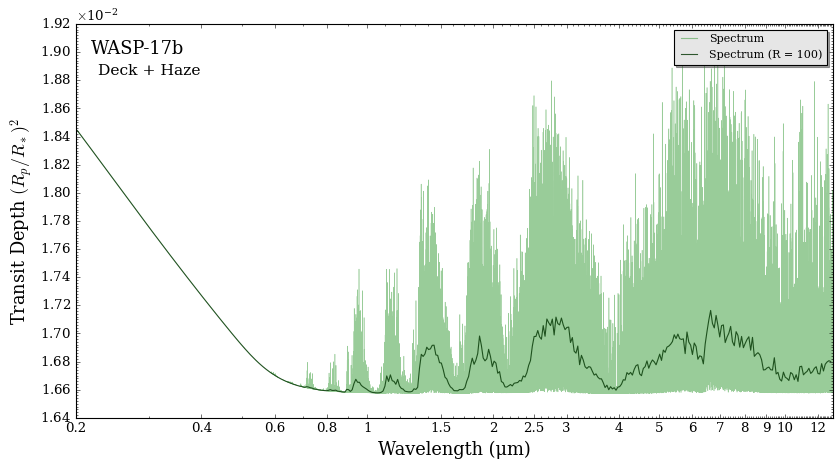

In [5]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_deck_haze = compute_spectrum(planet, star, model_deck_haze, 
                                      atmosphere_deck_haze, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_deck_haze, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Deck + Haze', save_fig = False,
                   figure_shape = 'wide') 

### Parameter Exploration: The Deck + Haze Model (MacMad17) 

Let's check out how the deck + haze is actually affecting the spectrum. 

Here, we will use the `spectral_contribution` helper function, which individually plots the contribution of each opacity source in the model to the resultant transmission spectrum. This function is covered in more depth in the tutorial [\"Transmission Spectra Model Visuals\"](transmission_contributions.html), but for now we will just use the function as-is to demonstrate how clouds are shaping the spectrum.

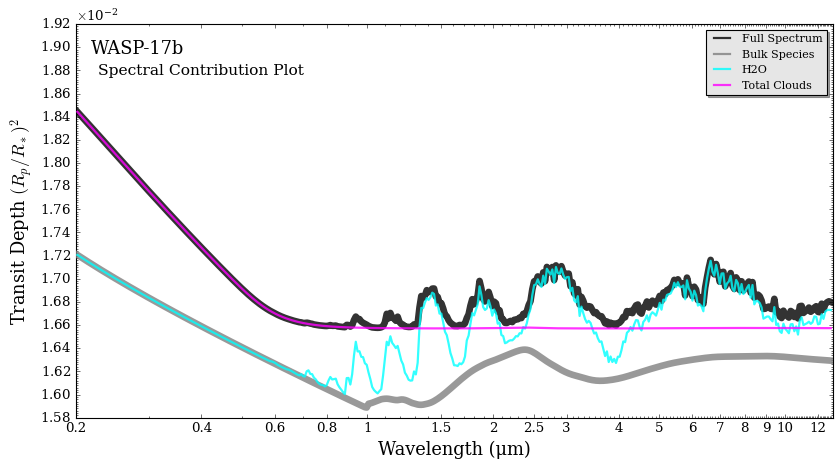

In [6]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, \
spectrum_contribution_list = spectral_contribution(planet, star, model_deck_haze, 
                                                   atmosphere_deck_haze, opac, wl,
                                                   contribution_species_list = ['H2O'],
                                                   bulk_species = True, 
                                                   cloud_contribution = True,
                                                   )

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, 
                                 spectrum_contribution_list, return_fig = True,
                                 line_widths = [6,6,2,2],
                                 colour_list = ['black', 'gray', 'cyan','magenta'],
                                 figure_shape = 'wide')

In the spectral contribution plot, we can see both the effect of the deck and the haze. 

The opaque cloud flattens the spectrum at wavelengths longer than about 0.6 μm, creating a spectral baseline that truncates the water features. The power-law haze imprints a slope that dominates shorter wavelengths.

We will now vary each cloud parameter individually to see how their values affect the model spectrum. For this we will use another helper function, `vary_one_parameter`.

* Rayleigh enhancement factor ($a$):

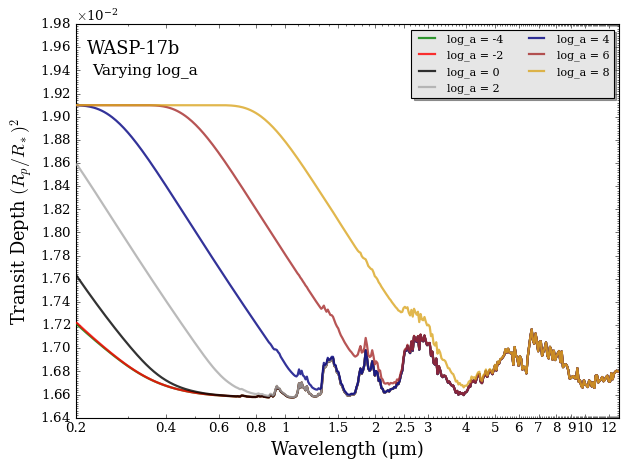

In [7]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'log_a'
vary_list = [-4,-2,0,2,4,6,8]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.64e-2, y_max = 1.98e-2,
                   )

* Scattering slope exponent ($\gamma$):

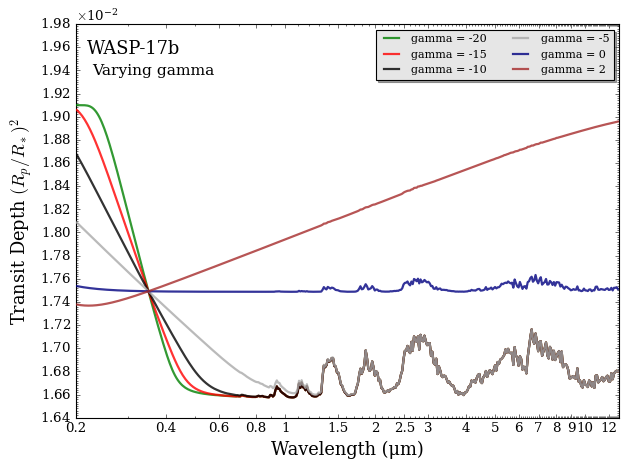

In [8]:
param_name = 'gamma'
vary_list = [-20,-15,-10,-5,0,2]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.64e-2, y_max = 1.98e-2,
                   )

* Cloud deck pressure ($P_{\rm{cloud}}$):

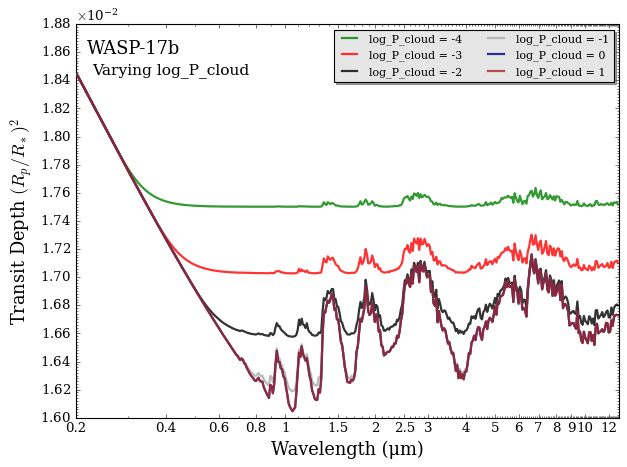

In [9]:
param_name = 'log_P_cloud'
vary_list = [-4,-3,-2,-1,0,1]

vary_one_parameter(model_deck_haze, planet, star, param_name, vary_list, wl, opac,
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.60e-2, y_max = 1.88e-2,
                   )

## Mie Scattering in POSEIDON

<div class="alert alert-info">

  **Note:**

  Mie scattering clouds are a new feature as of POSEIDON v1.2. If you installed POSEIDON before September 2024, you will need to re-download the input files to access the new aerosol database and use these features.

</div>

### A Brief Introduction to Mie Scattering 

Now that we have looked at a simple parametric cloud model, let's move to more complex models that consider the specific chemical composition of the aerosols in the atmosphere. For aerosols, like gas species, exhibit their own complex wavelength-dependent absorption properties (alongside scattering) depending on their composition.

Aerosol particles scatter radiation depending on how big they are compared to the wavelength of light they are interacting with (according to the size parameter, $x = 2 \pi r/ \lambda$). When aerosols are 'small' ($x << 1$), they are in the Rayleigh and Raman scattering regime where scattering processes are described purely by standard electromagnetism. When aerosols are 'large' ($x >> 1$), they are in the geometric optics regime where aerosols scatter light according to classical optics (ray-tracing, refraction, diffraction, internal reflection). For aerosols with similar size to the wavelength of light ($x \sim 1$), one must deal with the more general Mie scattering regime in which both electromagnetic and optical effects are important considerations. Mie theory was solved way back in 1908 (in a 90 page document we would rather spare you from) directly from Maxwell's equations, but for our purposes we will stress that the full solution for aerosols scattering and absorption depends on *just* two parameters: (i) the complex refractive index (as a function of wavelength), and (ii) the size parameter.

### Mie Scattering Optical Properties

POSEIDON v1.2 includes an extensive database of over pre-computed Mie scattering properties for over 70 aerosol species of potential importance in exoplanet and brown dwarf atmospheres (catalogued in [\"Opacity Database\"](../opacity_database.html)). Transmission spectra can be generated from these pre-computed Mie scattering aerosol properties, or alternatively for user-inputted aerosols or aerosols with a constant refractive index.

We will first take a look at how to access the optical properties of aerosols in POSEIDON's pre-computed Mie scattering database, and also bestow upon you the dread power of directly computing aerosol optical properties using the Mie algorithm in POSEIDON.

POSEIDON currently supports three different types of aerosol inputs. 

1) Aerosols in the pre-computed database.
2) User-provided aerosol refractive indices.
3) Aerosols with constant refractive indices.

For more details on the assumptions that went into pre-computing the optical properties aerosols in POSEIDON's aerosol database, please see the tutorial [\"Making an Aerosol Database\"](aerosol_database.html).

For options (2) or (3) above, POSEIDON uses a Mie scattering algorithm to calculate the aerosol extinction cross section and other optical properties 'on the fly'. This functionality is good for quick forward models, but would be prohibitively slow for retrievals. Therefore, for retrieval purposes  users can also add their own aerosol properties directly to POSEIDON's aerosol database (see '[\"Making an Aerosol Database\"](aerosol_database.html)).

This section covers aerosol optical properties. Creating atmospheric models with the three different types of Mie scattering aerosols with specific vertical distributions will be described in the next section. 

#### 1. Pre-computed Database of Mie Scattering Aerosols

Let's check the available species in POSEIDON's aerosol database:

In [10]:
from POSEIDON.supported_chemicals import aerosol_supported_species

print(aerosol_supported_species)

['ADP' 'Al2O3' 'Al2O3_KH' 'C' 'CH4_liquid' 'CH4_solid' 'CaTiO3'
 'CaTiO3_KH' 'Cr' 'ExoHaze_1000xSolar_300K' 'ExoHaze_1000xSolar_400K' 'Fe'
 'Fe2O3' 'Fe2SiO4_KH' 'FeO' 'FeS' 'FeSiO3' 'H2O' 'H2O_ice' 'H2SO4'
 'Hexene' 'Hibonite' 'IceTholin' 'KCl' 'Mg2SiO4_amorph_sol_gel'
 'Mg2SiO4_amorph' 'Mg2SiO4_Fe_poor' 'Mg2SiO4_Fe_rich'
 'Mg2SiO4_crystalline' 'Mg4Fe6SiO3_amorph_glass' 'Mg5Fe5SiO3_amorph_glass'
 'Mg8Fe12SiO4_amorph_glass' 'Mg8Fe2SiO3_amorph_glass' 'MgAl2O4'
 'MgFeSiO4_amorph_glass' 'MgO' 'MgSiO3_amorph' 'MgSiO3_crystalline'
 'MgSiO3' 'MgSiO3_amorph_glass' 'MgSiO3_sol_gel' 'MnS' 'MnS_KH' 'MnS_Mor'
 'Na2S' 'NaCl' 'NanoDiamonds' 'NH3' 'NH4SH' 'S8' 'Saturn-Phosphorus-Haze'
 'SiC' 'SiO' 'SiO2' 'SiO2_amorph' 'SiO2_crystalline_2023'
 'SiO2_alpha_palik' 'SiO2_glass_palik' 'Soot' 'Soot_6mm' 'Tholin'
 'Tholin-CO-0625' 'Tholin-CO-1' 'TiC' 'TiO2_anatase' 'TiO2_rutile' 'VO'
 'ZnS' 'MgSiO3_r_m_std_dev_01' 'MgSiO3_r_m_std_dev_1'
 'MgSiO3_g_w_calc_mean' 'MgSiO3_g_w_calc_trap']


Let's now pick $\rm{SiO_2}$ as a specific aerosol species and query the pre-computed aerosol database directly.

POSEIDON's aerosol database contains the optical properties of aerosols (effective extinction cross section, single scattering albedo, and asymmetry parameter — see Mullens et al. 2024) as a function of mean particle size ($r_m$) and wavelength.

By querying the database directly, we can preview the $\rm{SiO_2}$ cross section before we put it in our models.

<div class="alert alert-info">

  **Note:**

  Loading the aerosol database directly, as shown below, is not necessary for running forward models and retrievals. This is just to show how to do so if you wish to explore the scattering and absorption properties of an aerosol species.

</div>

In [11]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid

species = 'SiO2'

# Load in the aerosol grid 
aerosol_grid = load_aerosol_grid([species])

# Specify mean radius of the aerosol particles
r_m = 0.01

# Loads effective extinction cross section
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Extract the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_abs = sigma_Mie_interp_array[species]['eff_abs']
eff_scat = sigma_Mie_interp_array[species]['eff_scat']
eff_back = sigma_Mie_interp_array[species]['eff_back']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


Let's plot the effective extinction cross section for $\rm{SiO_2}$.

The effective extinction cross section encodes the loss of photons to the beam due to the combination of absorption and scattering. This quantity is especially useful for transmission spectra, since a significant fraction of scattered radiation will be directed out of the line of sight to a distant observer.

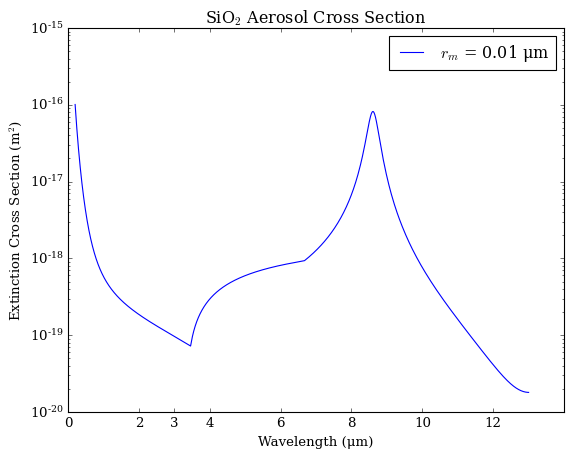

In [12]:
import matplotlib.pyplot as plt

label = '$r_m$ = ' + str(r_m) + ' μm'
title = 'SiO$_2$ Aerosol Cross Section'

plt.semilogy(wl, eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelength (μm)')
plt.ylabel('Extinction Cross Section (m$^2$)')
plt.xticks((0,2,3,4,6,8,10,12))
plt.show()

We see that $\rm{SiO_2}$ has an absorption feature around 8 μm and a scattering slope at shorter wavelengths. One key benefit to using compositionally specific aerosols (in lieu of the parametrised deck + power-law haze above) is that you get both a scattering slope and a compositionally-specific mid-infrared wavelength absorption feature. So if you detect an aerosol feature in the mid-infrared, you can identify which aerosol species is in a planet's atmosphere!

The other optical properties (single scattering albedo and asymmetry parameter) are explored further in the [\"Thermal Scattering\"](emission_scattering.html) and [\"Reflection in Hot Jupiters\"](reflection.html) tutorials.

#### 2. User-provided Refractive Indices

Here, we will load refractive indices for water aerosols. 

We recommend loading refractive indices and testing them in couple of forward models to make sure they behave the way you expect. After confirming their validity, you can add the species manually to POSEIDON's aerosol database (see [\"Making an Aerosol Database\"](aerosol_database.html).

Let's first load the complex refractive index of $\rm{H_2 O}$.

Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/WS15/H2O_complex.txt


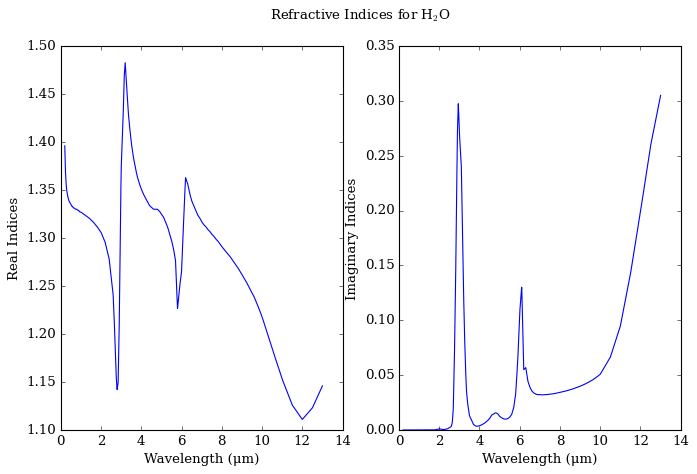

<Figure size 640x480 with 0 Axes>

In [13]:
from POSEIDON.clouds import plot_refractive_indices_from_file

# Load H2O refractive index file
refractive_index_path = '../../../POSEIDON/reference_data/refractive_indices_txt_files/WS15/'
file_name = refractive_index_path + 'H2O_complex.txt'

# Plot the refractive index
plot_refractive_indices_from_file(wl, file_name, species = 'H$_2$O')

Now we can use POSEIDON's Mie algorithm backend to compute the effective cross sections, the single scattering albedo, and the asymmetry parameter. Transmission geometries only use the effective extinction cross section, while emission geometries with scattering and/or reflection make use of the effective extinction cross section, the single scattering albedo, and the asymmetry parameter.

<div class="alert alert-info">

  **Note:**

  Mie scattering calculations typically take 5-10 seconds, depending on the size parameter, wavelength range etc.

</div>

Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/WS15/H2O_complex.txt


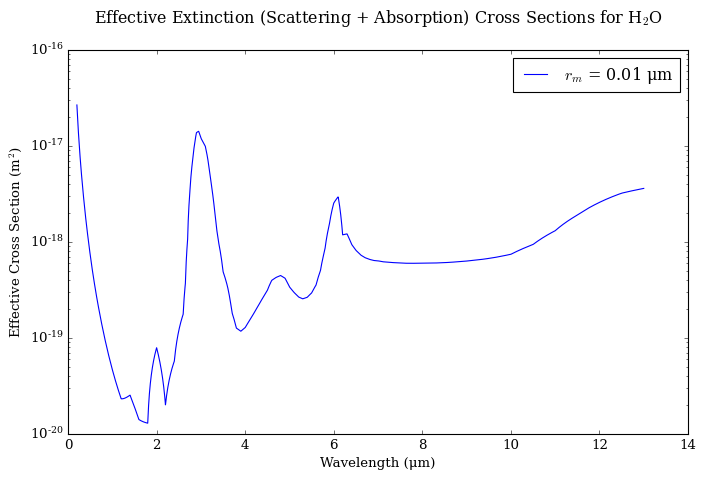

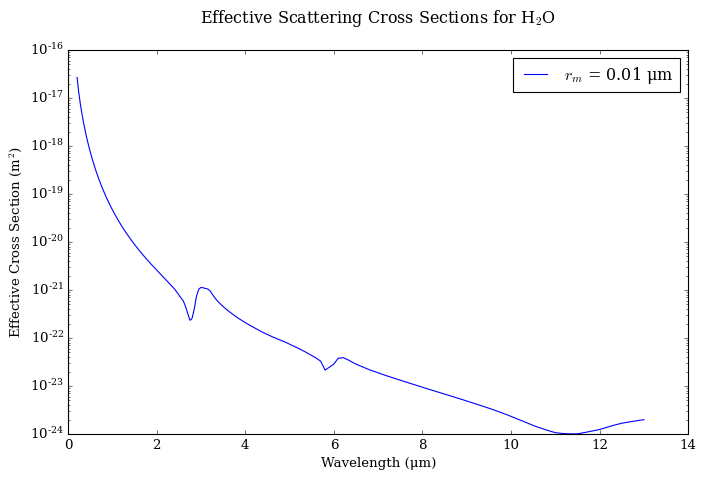

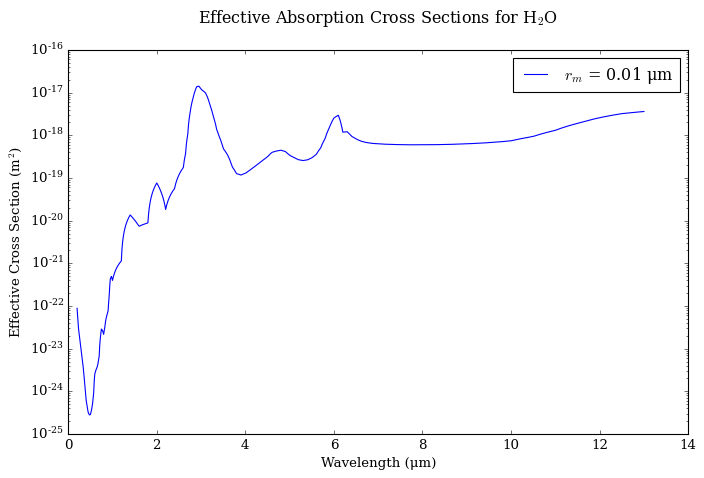

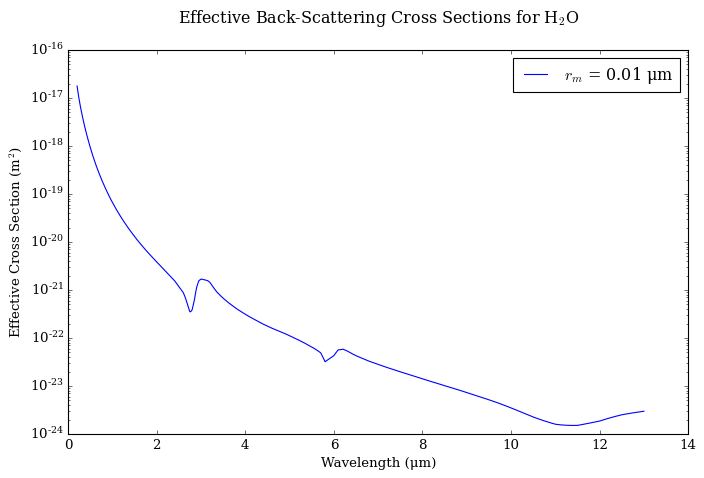

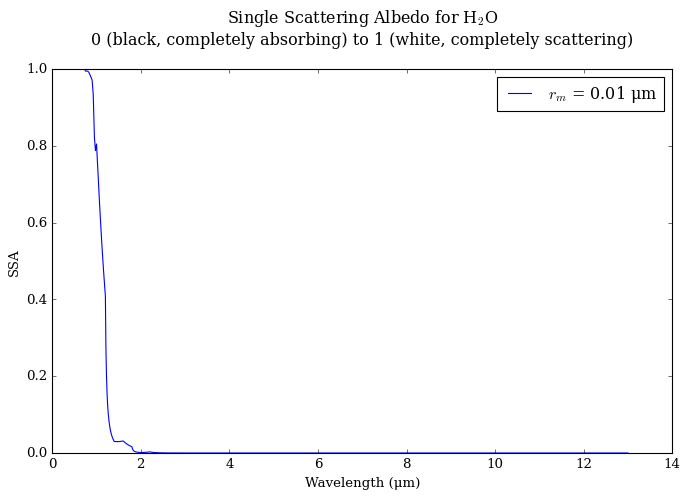

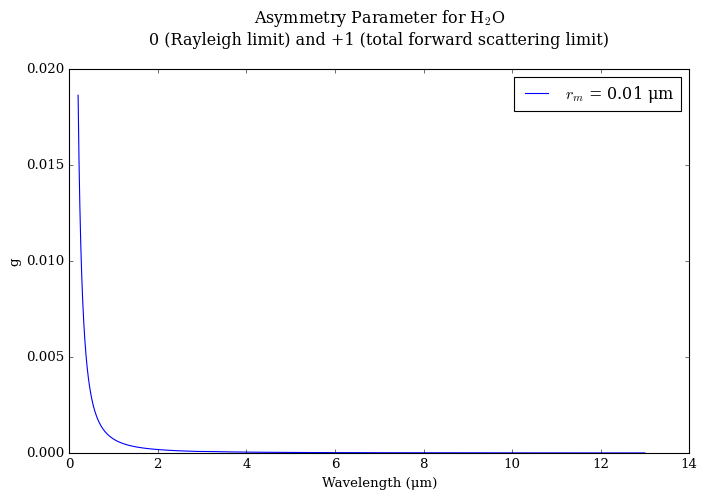

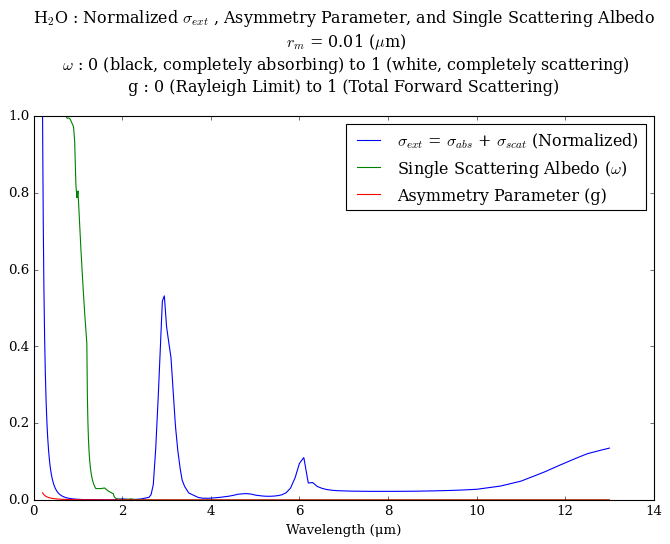

In [14]:
from POSEIDON.clouds import compute_and_plot_aerosol_cross_section_from_file

# Mean particle size
r_m = 0.01

# Run the Mie scattering calculation
compute_and_plot_aerosol_cross_section_from_file(wl, r_m, file_name, species = 'H$_2$O')

We will see later in this tutorial how to use such user-calculated aerosol properties to make transmission spectra with POSEIDON.

#### 3. Constant Refractive Index 

Here, you just define the real and imaginary components of the refractive index, which will be assumed to be constant in wavelength.

As you can see below, this prescription results in something similar to the power-law haze shown before. 

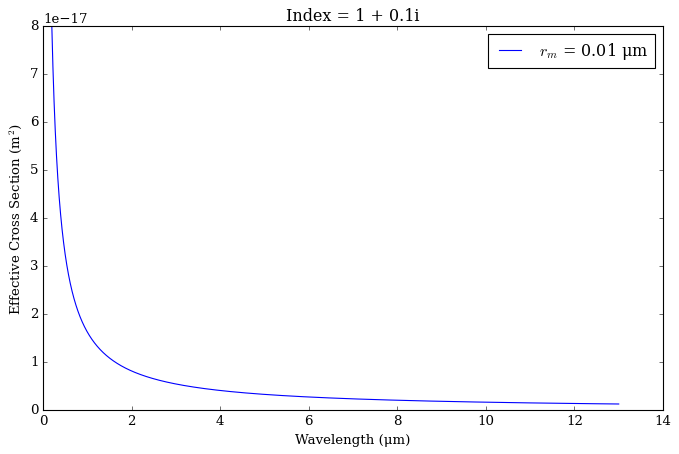

In [15]:
from POSEIDON.clouds import compute_and_plot_effective_cross_section_constant

# Mean particle size
r_m = 0.01

# Real and imaginary parts of the refractive index
ref_index_real = 1
ref_index_imaginary = 0.1

compute_and_plot_effective_cross_section_constant(wl, r_m, ref_index_real, ref_index_imaginary)

Now that we have seen wavelength-dependent optical properties, let's move on to describing the vertical distribution of said aerosols (required to calculate a spectrum!).

### Mie Scattering Clouds: Vertical Distribution Models 

POSEIDON has myriad prescriptions to describe the distribution of aerosols in a planetary atmosphere.

A few of these cloud models are new to POSEIDON v1.2 and are specific to Mie scattering aerosols:

1. Fuzzy Deck.
2. Slab.
3. Uniform X.

The first two models are illustrated in the diagram below (from Mullens et al. 2024).

We will see now how each aerosol distribution model influences transmission spectra.

<img src="../../_static/notebook_images/Cloud-Models.png" />

#### General Procedure for Defining a Mie Scattering Cloud Model in POSEIDON v1.2

When defining a Mie scattering cloud model, you will need to: 

1. Set `cloud_model = 'Mie'`.

2. Select the `cloud_type` (e.g. 'fuzzy_deck', 'slab', 'uniform_X').

3. Define your `aerosol_species`:
- For the pre-computed database, provide the species name (e.g. `SiO2`).
- **OR**  if you are using your own aerosol data, then use `file_read`.
- **OR**  if you are using a constant refractive index, then use `free`.

You can also include multiple aerosol species from the pre-computed database and use hybrid cloud types that combine different vertical distributions.

We will see several specific examples now. 


#### Fuzzy Deck Model

The fuzzy deck model is adapted from [Zhang et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PASP..131c4501Z/abstract). In essence, this model is similar to the deck + haze described before in that there is an opaque cloud deck located at $P_{\rm{cloud}}$ plus an aerosol species above the deck. 

The free parameters for the fuzzy deck model are: 

* $\log(P_{\mathrm{top, \, deck}})$ : The cloud top pressure of the opaque part of the cloud.

* $\log(n_{\rm{max}})$   : The maximum aerosol number density (defines the number density at the cloud top).

* $\log(r_m)$     : The mean aerosol particle size in μm (log = -3 -> 0.001 μm). Ranges from -3 to +2 for species in the aerosol database.

* $f$           : The fractional scale height relative to the background atmosphere scale height (determines how rapidly the number density falls off with height, such that $f \approx 0$ implies no fuzziness and $f \approx 1$ implies a constant aerosol mixing ratio above the deck).

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

* $r_{\mathrm{i, \, real}}$ and $r_{\mathrm{i, \, complex}}$: The real and imaginary components of the refractive index. 

The number density of aerosols above the cloud deck is then given by
$$
\begin{equation}
n = n_{\rm{max}} \; \exp\left(\frac{-h}{f H_{gas}}\right)
\end{equation} 
$$

where $h$ is the height above the cloud deck and $H_{\rm{gas}}$ is the scale height.

Let's now create an atmosphere using the fuzzy deck model.

In [16]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Fuzzy_Deck_SiO2'

bulk_species = ['H2', 'He']
param_species = ['H2O']

# Set aerosol species
aerosol_species = ['SiO2']  # <---- Put aerosol species here

# Define model
model_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                                PT_profile = 'isotherm', X_profile = 'isochem',
                                cloud_model = 'Mie',                 # <---- Put cloud model here (Mie)
                                cloud_type = 'fuzzy_deck',           # <---- Put cloud type here 
                                aerosol_species = aerosol_species,   # <---- Put aerosol species list here 
                                )   


# Check the free parameters defining this model
print("PT parameters : " + str(model_fuzzy_deck['PT_param_names']))
print("X parameters : " + str(model_fuzzy_deck['X_param_names']))
print("Cloud parameters : " + str(model_fuzzy_deck['cloud_param_names'])) # <---- Print the cloud param names

Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_deck_SiO2' 'log_r_m_SiO2' 'log_n_max_SiO2' 'f_SiO2']


In [17]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_deck_SiO2 = 0     # <---- Top of the opaque deck is at 1 bar (extends from 100 to 1 bar)
log_r_m_SiO2        = -2    # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_n_max_SiO2      = 20    # <---- The number density of SiO2 at the top of the opaque deck (at 1 bar)
f_SiO2              = 0.3   # <---- The fuzziness of aerosols (how number density evolves above the cloud deck)

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

# Make atmosphere 
atmosphere_fuzzy_deck = make_atmosphere(planet, model_fuzzy_deck, P, P_ref, R_p_ref, 
                                        PT_params, log_X_params, cloud_params)

Let's see this parametrisation in action by using helper functions to plot how the aerosols are distributed in the forward model atmosphere we just created. We'll visualize the fuzzy deck model in terms of both number density and volume mixing ratio.

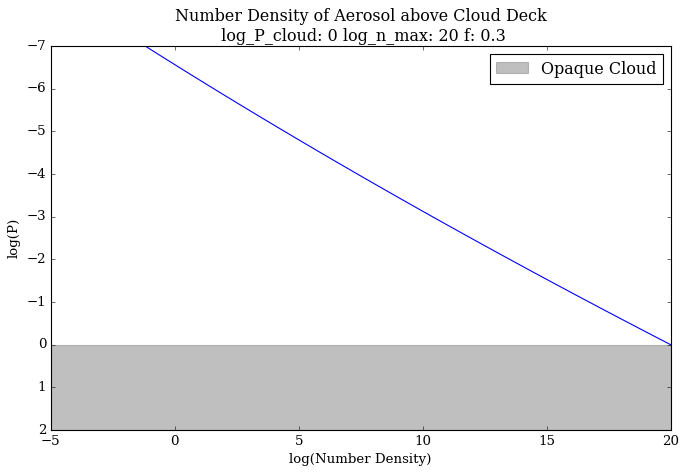

Max mixing ratio :  -4.7807354712741414
Min mixing ratio :  -18.970141147170185


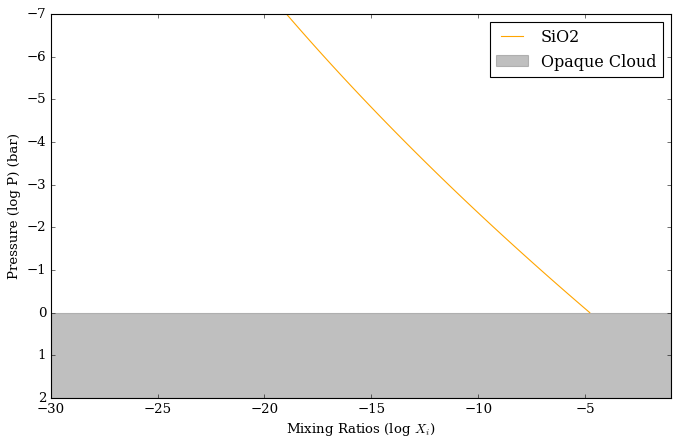

In [18]:
from POSEIDON.clouds import plot_aerosol_number_density_fuzzy_deck, plot_clouds

# Plot the aerosol number density profile
plot_aerosol_number_density_fuzzy_deck(atmosphere_fuzzy_deck,log_P_top_deck_SiO2,log_n_max_SiO2,f_SiO2)

# Plot the aerosol mixing ratio profile
plot_clouds(planet,model_fuzzy_deck,atmosphere_fuzzy_deck)

And finally, we can make a spectrum using Mie scattering!

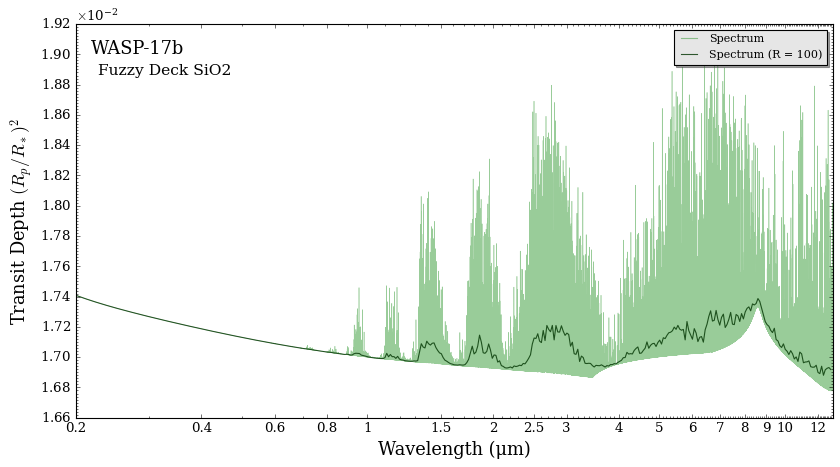

In [19]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_fuzzy_deck = compute_spectrum(planet, star, model_fuzzy_deck, 
                                       atmosphere_fuzzy_deck, opac, wl,
                                       spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_fuzzy_deck, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Fuzzy Deck SiO2',
                   save_fig = False,
                   figure_shape = 'wide',
                   ) 

Aha! I spy an absorption feature near 8-9 μm!

Let's analyse what is happening using our favourite spectral decomposition helper function. 🔍

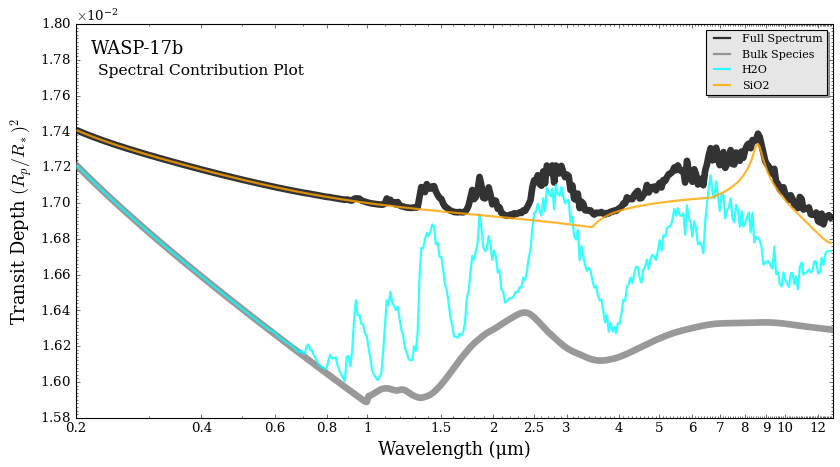

In [22]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, \
spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck, 
                                                   atmosphere_fuzzy_deck, opac, wl,
                                                   contribution_species_list = ['H2O'],
                                                   cloud_species_list = ['SiO2'],
                                                   bulk_species = True, 
                                                   cloud_contribution = True,
                                                   )

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, 
                                 spectrum_contribution_list,
                                 return_fig = True,
                                 line_widths = [6,6,2,2],
                                 colour_list = ['black', 'gray', 'cyan', 'orange'],
                                 y_min = 1.58e-2, y_max = 1.80e-2,
                                 )

We can see that the $\rm{SiO2}$ fuzzy deck parameterization is generating a shallow slope from 0.2 to 3.5 μm with its scattering properties, while also imparting an absorption feature between 8-9 μm. 

Let's now use the helper function `vary_one_parameter` to explore how each parameter of the fuzzy deck model directly affects the resultant transmission spectrum.

* Cloud deck pressure ($P_{\mathrm{top, \, deck}}$):

Reading in database for aerosol cross sections...


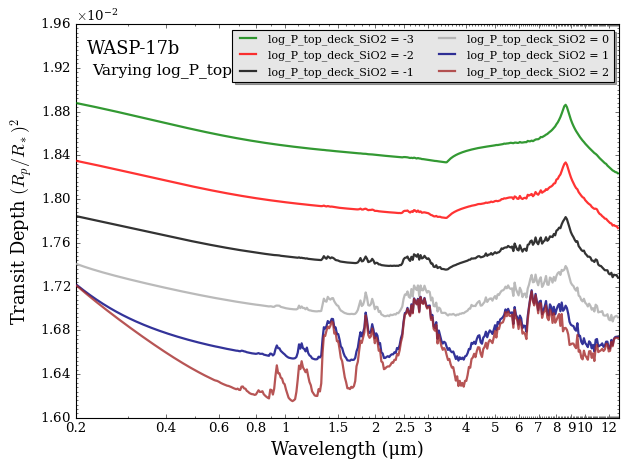

In [32]:
param_name = 'log_P_top_deck_SiO2'
vary_list = [-3,-2,-1,0,1,2]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.60e-2, y_max = 1.96e-2,
                   )

* Mean particle size ($r_m$).

Reading in database for aerosol cross sections...


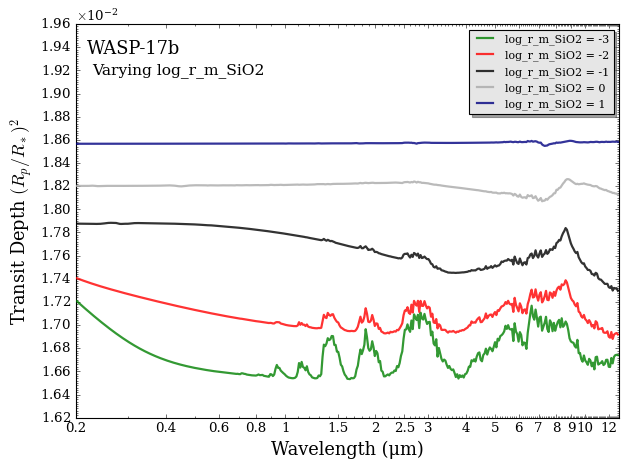

In [34]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.62e-2, y_max = 1.96e-2,
                   )

We see that as the particle gets larger the opacity becomes more 'gray'-like, which produces a flat spectrum. 

* Maximum number density ($n_{\rm{max}}$):

Reading in database for aerosol cross sections...


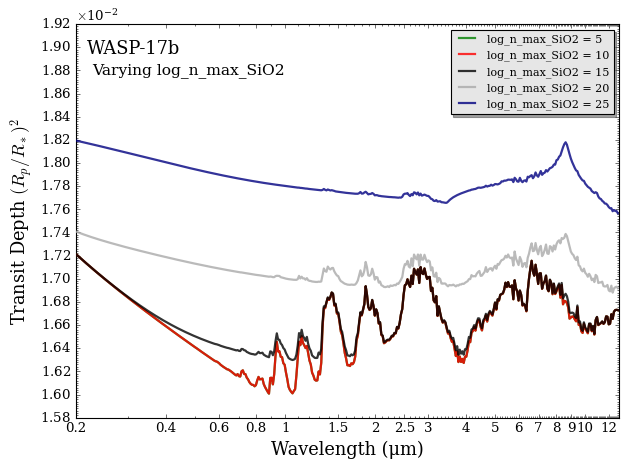

In [38]:
param_name = 'log_n_max_SiO2'
vary_list = [5,10,15,20,25]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.58e-2, y_max = 1.92e-2,
                   )

* Cloud fractional scale height ($f$):

Reading in database for aerosol cross sections...


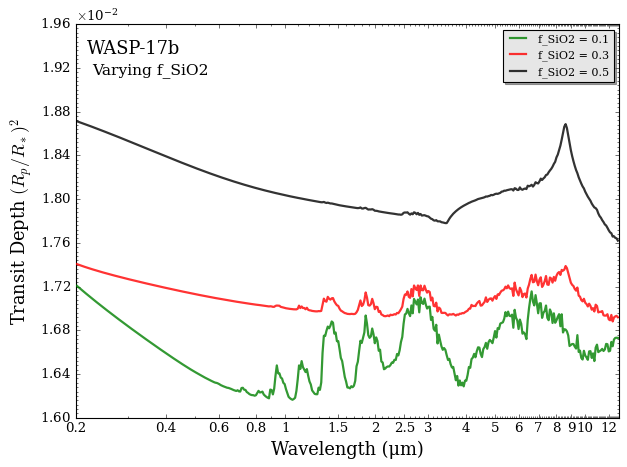

In [40]:
param_name = 'f_SiO2'
vary_list = [0.1,0.3, 0.5]

vary_one_parameter(model_fuzzy_deck, planet, star, param_name, vary_list, wl, opac, 
                   P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   y_min = 1.60e-2, y_max = 1.96e-2,
                   )

#### Slab Model

The slab model places a cloud spanning pressure space (from log_P_cloud_top to log_P_cloud_top + Delta_P) where an aerosol has a constant mixing ratio in that pressure range. The model is defined by : 

$log(P_{top, slab})$ : The pressure at which the top of the slab is located

$\Delta log(P)$ : The range the slab extends

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um). Ranges -3 to 2 for aerosols in the database.

$log(X)$        : Mixing ratio of aerosol species within the slab

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 


In [25]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_slab = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'slab',               # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 


# Check the free parameters defining this model
print("PT parameters : " + str(model_slab['PT_param_names']))
print("X parameters : " + str(model_slab['X_param_names']))
print("Cloud parameters : " + str(model_slab['cloud_param_names']))  # <---- Print the cloud param names


Reading in database for aerosol cross sections...
PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


In [26]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_slab_SiO2 = -5  # <---- The top of the slab in pressure space (at 1e-5 bars)
Delta_log_P_SiO2    = 2   # <---- Extend of the slab in pressure space (extends down to 1e-3 bars)
log_r_m_SiO2        = -2  # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12 # <---- Volume mixing ratio of aerosol in the slab (1e-5 to 1e-3 bars)

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = ([log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2])

# Make atmosphere 
atmosphere_slab = make_atmosphere(planet, model_slab, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Again, let's visualize how aerosols are distributed in the forward model atmosphere.

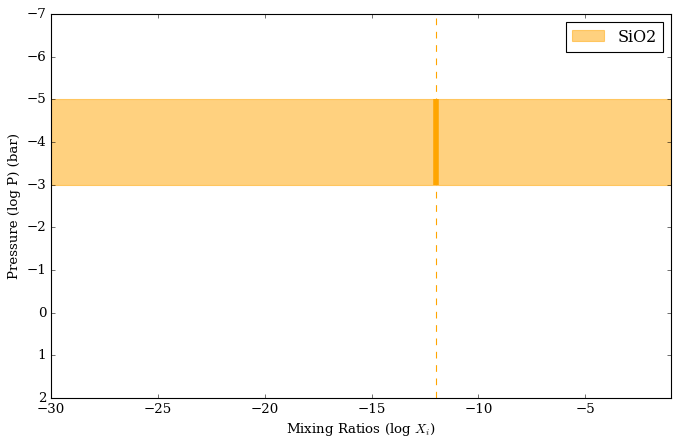

In [27]:
from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_slab,atmosphere_slab)

Let's generate the plot the spectrum

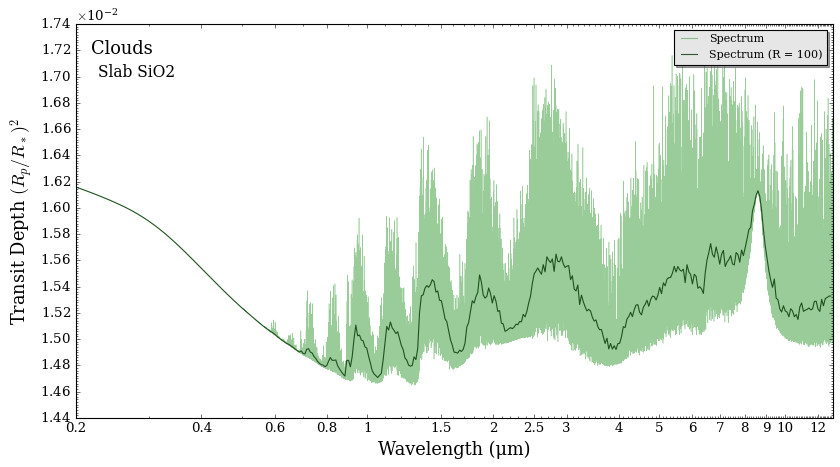

In [28]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_slab = compute_spectrum(planet, star, model_slab, atmosphere_slab, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_slab, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Slab SiO2',
                   save_fig = False,
                   figure_shape = 'wide') 

From above, we see a SiO2 scattering slope from 0.2 to 0.8 microns, and the same SiO2 absorption feature from 8-9 microns.

To visualize how SiO2's opacity changed between the fuzzy deck and slab models, let's use the spectral contribution plot again

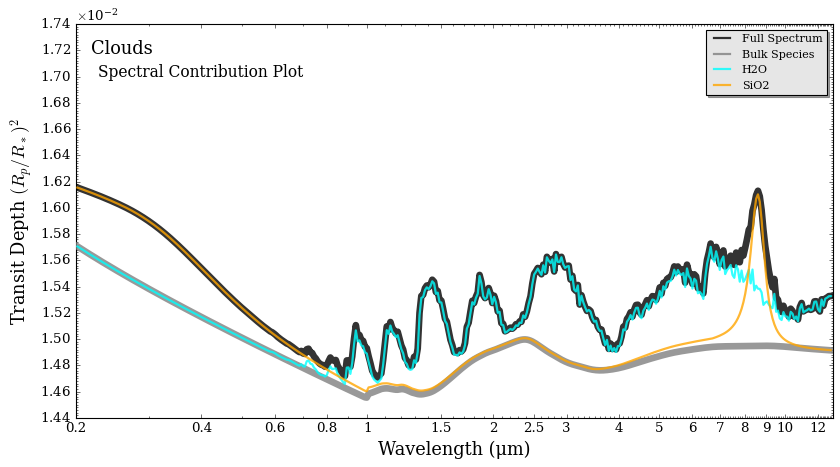

In [29]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star,  model_slab, atmosphere_slab, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

Let's go, one by one, and vary each parameter to see how they change the resultant transmission spectrum. 

As we discovered in the fuzzy deck parameter exploration above, the scattering and absorption opacity of aerosols are strongly tied to their particle size, while their strength is tied to the vertical extent and mixing ratio of the slab.

Reading in database for aerosol cross sections...


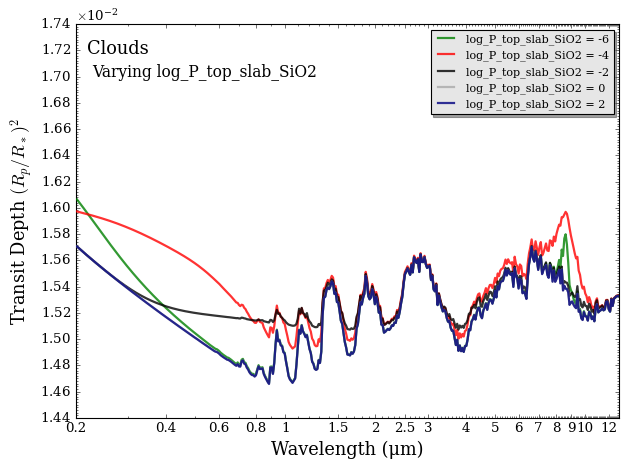

In [30]:
param_name = 'log_P_top_slab_SiO2'
vary_list = [-6,-4,-2,0,2]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


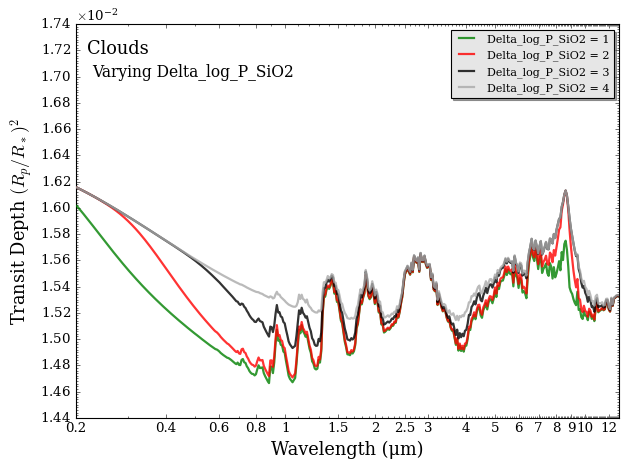

In [31]:
param_name = 'Delta_log_P_SiO2'
vary_list = [1,2,3,4]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


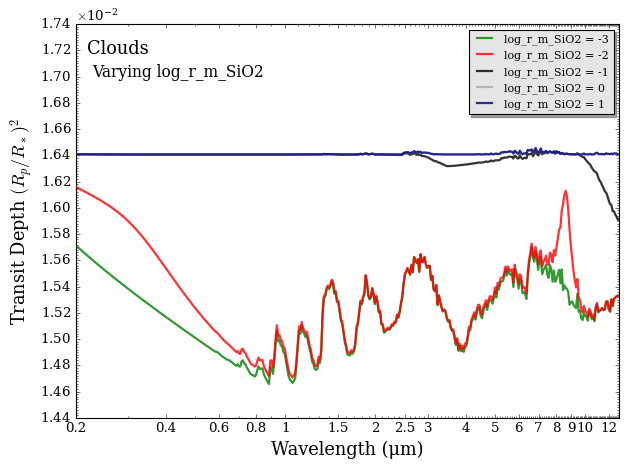

In [32]:
param_name = 'log_r_m_SiO2'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


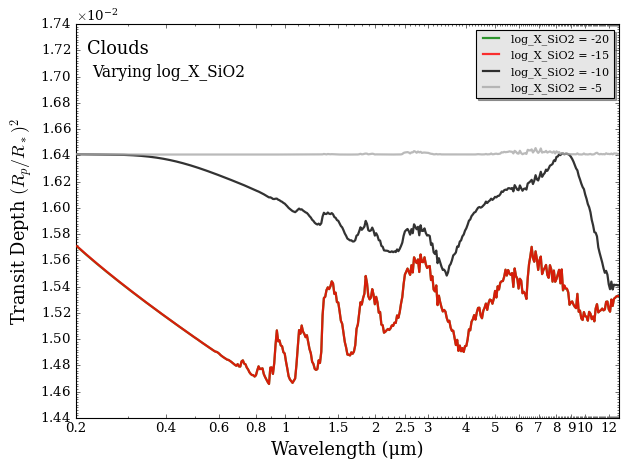

In [33]:
param_name = 'log_X_SiO2'
vary_list = [-20,-15,-10,-5]

vary_one_parameter(model_slab, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

#### Uniform X 

The uniform X model places a cloud spanning the entire pressure space where an aerosol has a constant mixing ratio. The model is defined by : 

$log(r_m)$     : The mean particle size in um (log = -3 -> 0.001 um)

$log(X)$        : Mixing ratio of aerosol species within the slab

Note that if you are loading in your own refractive indices, or using a constant refractive index, you will also need to define : 

$r_{i,real}$ and $r_{i,complex}$ are the real and complex components of the refractive index for the free case. 

In [ ]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2'] # <---- Put aerosol species here

model_uniform_x = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'uniform_X',          # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x['cloud_param_names'])) # <---- Print the cloud param names

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2']


Can also easily add multiple species to this model

In [ ]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_uniform_x_two = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'uniform_X',          # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x_two['cloud_param_names'])) # <---- Print the cloud param names

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2' 'log_r_m_MgSiO3' 'log_X_MgSiO3']


In [ ]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

log_r_m_SiO2        = -2  # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12 # <---- Volume mixing ratio of aerosol throughout the entire atmosphere

cloud_params = ([log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x = make_atmosphere(planet, model_uniform_x, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

log_r_m_SiO2        = -2     # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12    # <---- Volume mixing ratio of aerosol throughout the entire atmosphere
log_r_m_MgSiO3        = -2.5 # <---- Mean particle size of the MgSiO3 aerosols is 1e-2.5 microns
log_X_MgSiO3          = -10  # <---- Volume mixing ratio of aerosol throughout the entire atmosphere

cloud_params = ([log_r_m_SiO2, log_X_SiO2, log_r_m_MgSiO3, log_X_MgSiO3])
                 
atmosphere_uniform_x_two = make_atmosphere(planet, model_uniform_x_two, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


Let's plot the mixing ratio of SiO2 in the forward model atmosphere

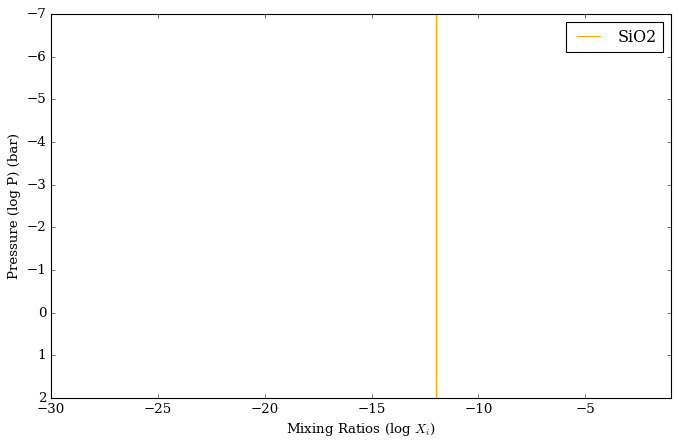

In [ ]:
plot_clouds(planet,model_uniform_x,atmosphere_uniform_x)

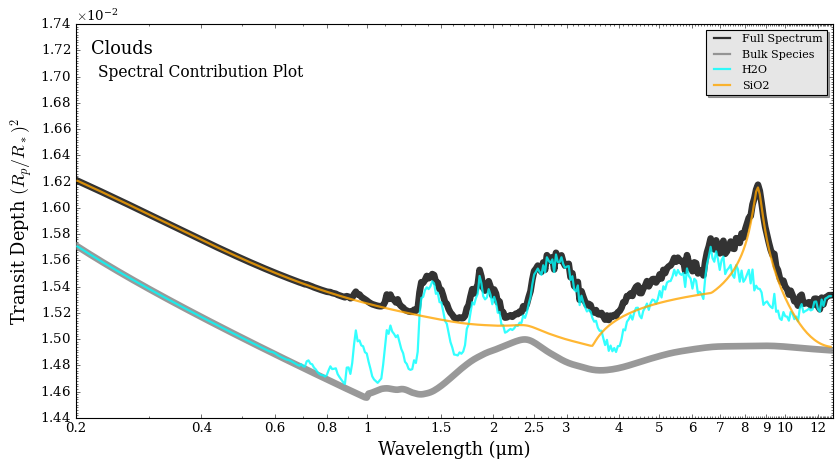

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x,atmosphere_uniform_x, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

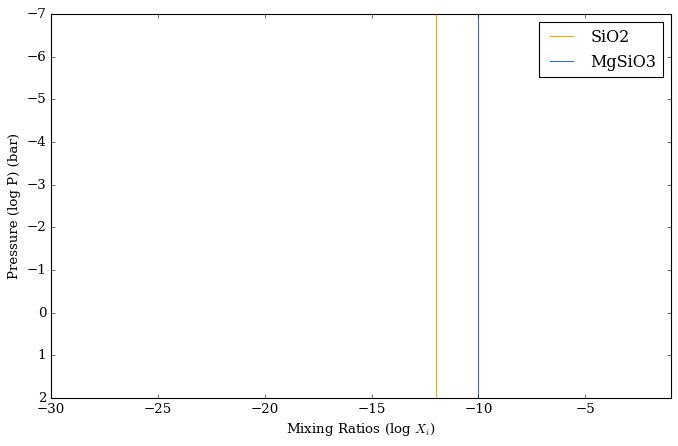

In [ ]:
plot_clouds(planet,model_uniform_x_two,atmosphere_uniform_x_two)

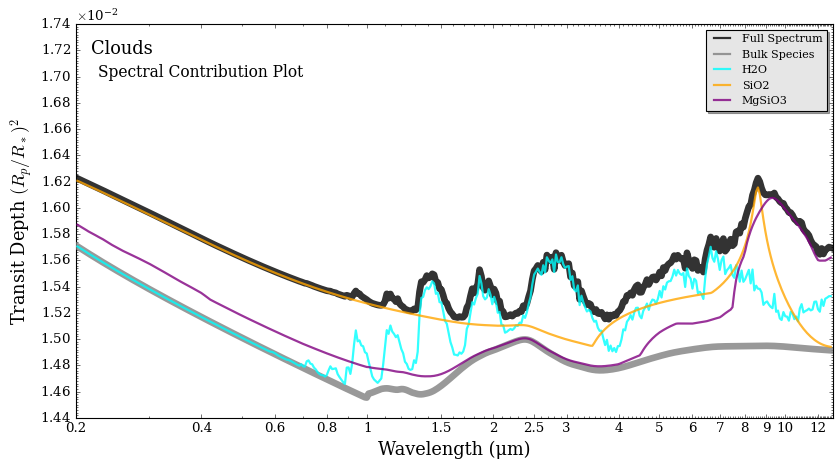

In [ ]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x_two,atmosphere_uniform_x_two, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

#### Advanced: Hybrid Slab and Fuzzy Deck Models

You can define multiple slabs where each aerosol is a seperate slab in the model. 

We can also combine a slab with an opaque deck, and combine a slab and a fuzzy deck model.

In [34]:
model_name = 'Multiple_Slabs'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_multiple_slabs = define_model(model_name, bulk_species, param_species,
                                    PT_profile = 'isotherm', X_profile = 'isochem',
                                    cloud_model = 'Mie',cloud_type = 'slab', # <---- Put cloud type here 
                                    aerosol_species = aerosol_species) # <---- Put aerosol species list here 

model_name = 'Opaque_deck_plus_slab'

model_opaque_plus_slabs = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'isotherm', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'opaque_deck_plus_slab', # <---- Put cloud type here 
                                        aerosol_species = aerosol_species) # <---- Put aerosol species list here 

model_name = 'Fuzzy_deck_plus_slab'
aerosol_species = ['Fe','SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_fuzzy_deck_plus_slabs = define_model(model_name, bulk_species, param_species,
                                            PT_profile = 'isotherm', X_profile = 'isochem',
                                            cloud_model = 'Mie',cloud_type = 'fuzzy_deck_plus_slab', # <---- Put cloud type here 
                                            aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (slabs) : " + str(model_multiple_slabs['cloud_param_names']))
print()
print("Cloud parameters (opaque deck + slabs) : " + str(model_opaque_plus_slabs['cloud_param_names']))
print()
print("Cloud parameters (fuzzy deck + slabs) : " + str(model_fuzzy_deck_plus_slabs['cloud_param_names']))

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
This mode assumes that the first aerosol in the list is the deck species, rest are slab species
Reading in database for aerosol cross sections...

Cloud parameters (slabs) : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']

Cloud parameters (opaque deck + slabs) : ['log_P_top_deck' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2' 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']

Cloud parameters (fuzzy deck + slabs) : ['log_P_top_deck_Fe' 'log_r_m_Fe' 'log_n_max_Fe' 'f_Fe'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']


Let's define our two slabs (SiO2 and MgSiO3) to have different properties:

In [35]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12

log_P_top_slab_MgSiO3 = - 3
Delta_log_P_MgSiO3    = 1
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2, 
                 log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_multiple_slabs = make_atmosphere(planet, model_multiple_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


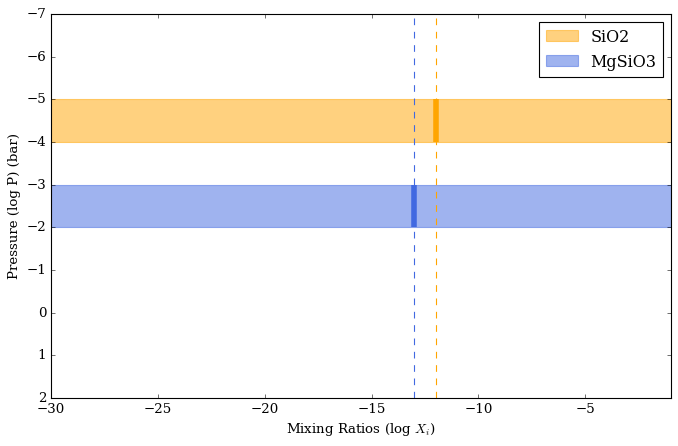

In [36]:
plot_clouds(planet,model_multiple_slabs,atmosphere_multiple_slabs)

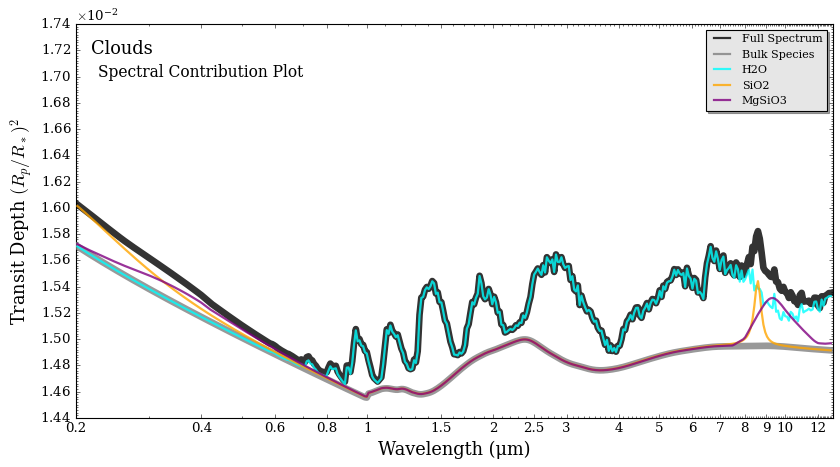

In [37]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_multiple_slabs,atmosphere_multiple_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

Now let's add an opaque deck to our multiple slab model (spanning 100 to 1e-2 bars)

In [38]:
# Opaque + Slabs
log_P_top_deck        = -2

cloud_params = ([log_P_top_deck,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_opaque_plus_slabs = make_atmosphere(planet, model_opaque_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Note that the contribution function does not show the deck seperately. However, as shown before, it just flattens the spectrum

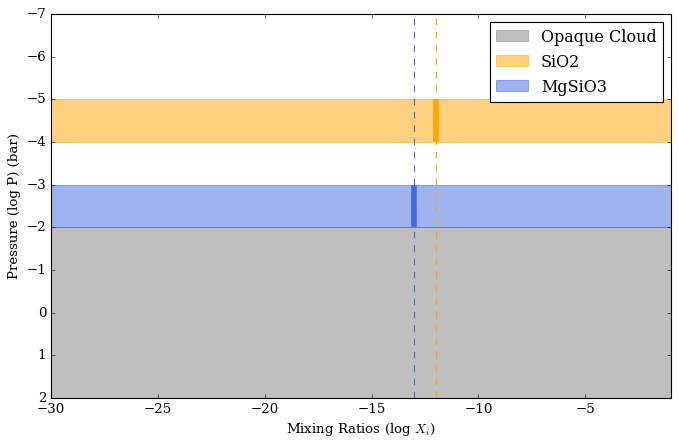

In [39]:
plot_clouds(planet,model_opaque_plus_slabs,atmosphere_opaque_plus_slabs)

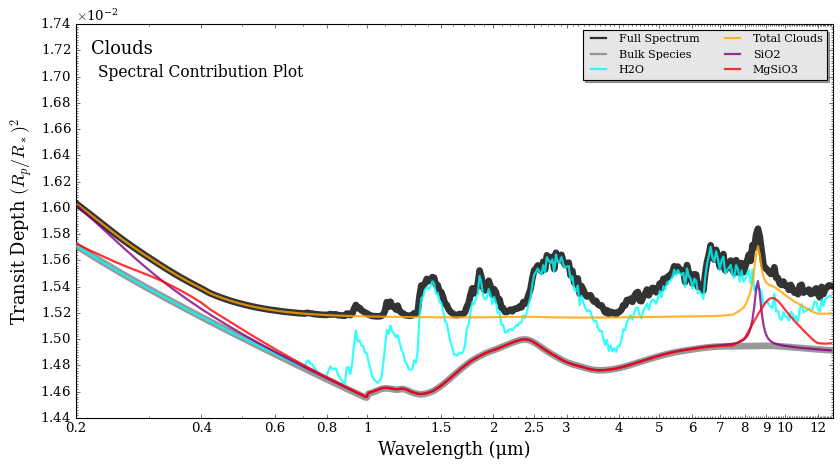

In [40]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_opaque_plus_slabs,atmosphere_opaque_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red'])

We can make the opaque deck a fuzzy iron deck instead:

In [41]:
# Fuzzy Deck + Slabs
log_P_top_deck_Fe     = 0
log_r_m_Fe            = -2
log_n_max_Fe          = 20
f_Fe                  = 0.2


cloud_params = ([log_P_top_deck_Fe,log_r_m_Fe,log_n_max_Fe,f_Fe,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3,log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_fuzzy_deck_plus_slabs = make_atmosphere(planet, model_fuzzy_deck_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

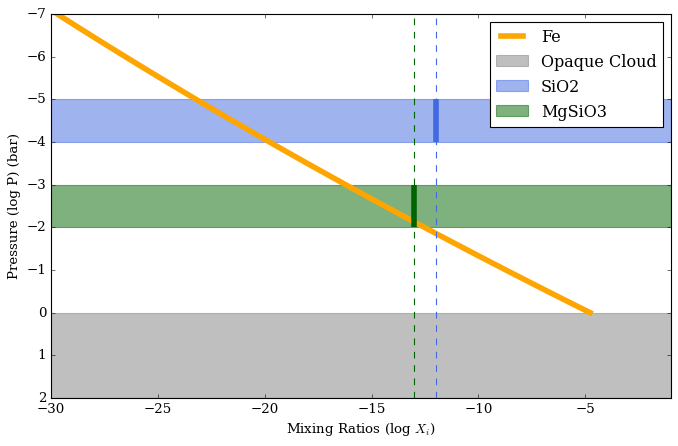

In [42]:
plot_clouds(planet,model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs)

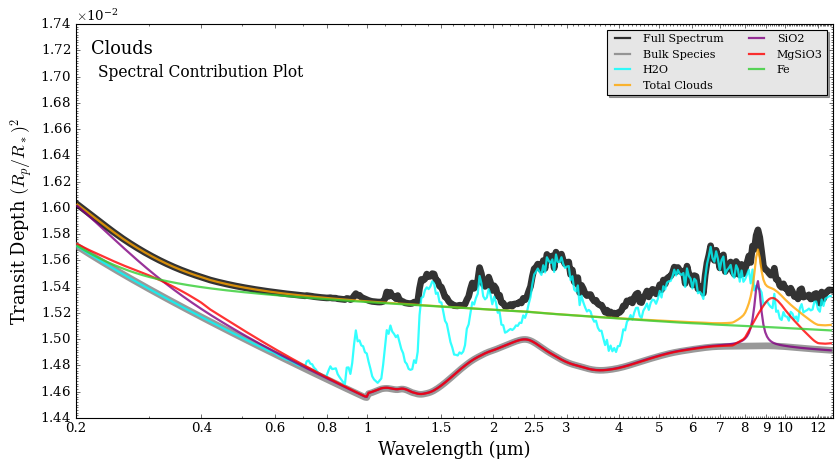

In [43]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3', 'Fe'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red', 'limegreen'])

There is also an option to define a slab so that multiple aerosol species share the same pressure extent, but differ in mixing ratio and radii. (This is good for retrievals since it knocks down the number of parameters)

In [44]:
model_name = 'One_Slab_Multiple_Species'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3']

model_one_slab_multiple_species = define_model(model_name, bulk_species, param_species,
                                                PT_profile = 'isotherm', X_profile = 'isochem',
                                                cloud_model = 'Mie',cloud_type = 'one_slab',
                                                aerosol_species = aerosol_species)

print("Cloud parameters (One Slab, Multiple Species) : " + str(model_one_slab_multiple_species['cloud_param_names']))

Reading in database for aerosol cross sections...
Cloud parameters (One Slab, Multiple Species) : ['log_P_top_slab' 'Delta_log_P' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']


In [45]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slab with multiple species
log_P_top_slab = -5
Delta_log_P    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab, Delta_log_P, log_r_m_SiO2, log_X_SiO2, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_one_slab_multiple_species = make_atmosphere(planet, model_one_slab_multiple_species, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

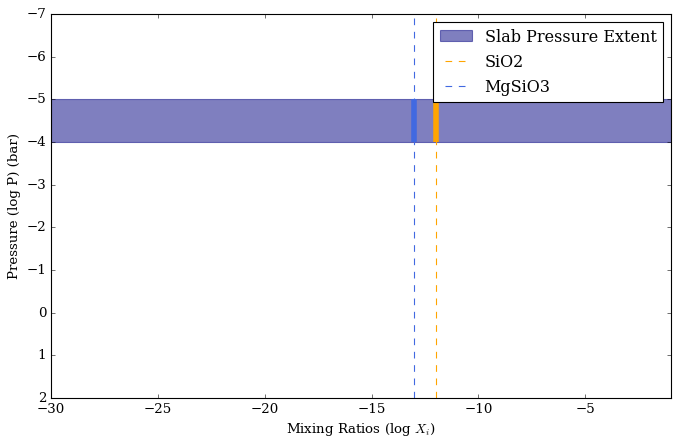

In [46]:
plot_clouds(planet,model_one_slab_multiple_species,atmosphere_one_slab_multiple_species)

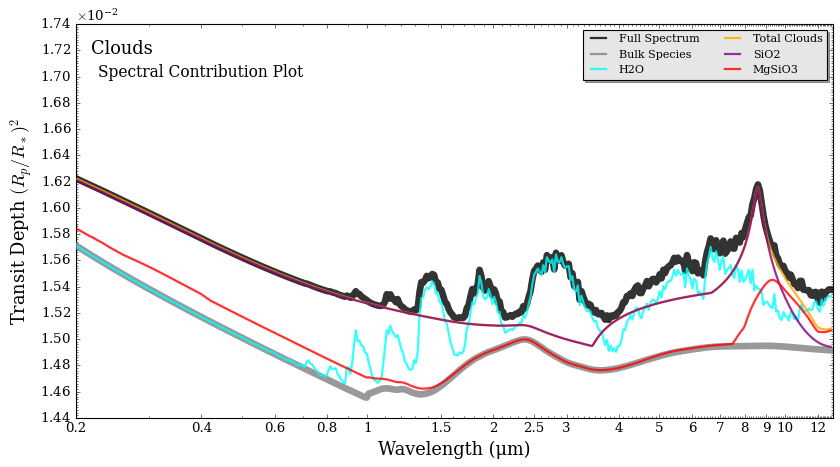

In [47]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_one_slab_multiple_species,atmosphere_one_slab_multiple_species, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3',],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red'])

#### Custom Aerosols

When not using the precomputed aerosol database, we can generate forward models directly from refractive index txt files or assuming a constant real and imaginary refractive index.

Now we have to provide the r_i_real and r_i_complex (refractive indices) into cloud params

Note that free and file read only work with the following cloud models : fuzzy deck, slab, uniform x, and opaque cloud plus slab. With free and file read aerosols, you can only have one slab (not multiple slabs)

Remember that using free or file read refractive indices will be slower, since cross sections have to be computed from scratch.

In [55]:
bulk_species = ['H2', 'He']     
param_species = ['H2O']

model_name = 'File_Read'
aerosol_species = ['file_read'] # <---- Put file_read here for using your own refractive index txt file

model_file_read = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

model_name = 'Free'
aerosol_species = ['free'] # <---- Put free here for constant real and imaginary refractive index
model_free = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (File Read) : " + str(model_file_read['cloud_param_names']))
print()
print("Cloud parameters (Free) : " + str(model_free['cloud_param_names']))


Cloud parameters (File Read) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']

Cloud parameters (Free) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']


Let's look at the file read first

In [56]:
from POSEIDON.clouds import load_refractive_indices_from_file

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Cloud Params 
log_r_m            = -2  # <---- Mean particle size of aerosol (1e-2 um)
log_X_Mie          = -12 # <---- Mixing ratio of aerosol throughout whole atmosphere

# Preload the refractive indices from the file 

file_name = './H2O_complex.txt' # <---- File path to refractive index txt file (wl r_i_real r_i_complex)

r_i_real, r_i_complex = load_refractive_indices_from_file(wl, file_name) # <---- Load in the real and imaginary indieces

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])

atmosphere_file_read = make_atmosphere(planet, model_file_read, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Loading in :  ./H2O_complex.txt


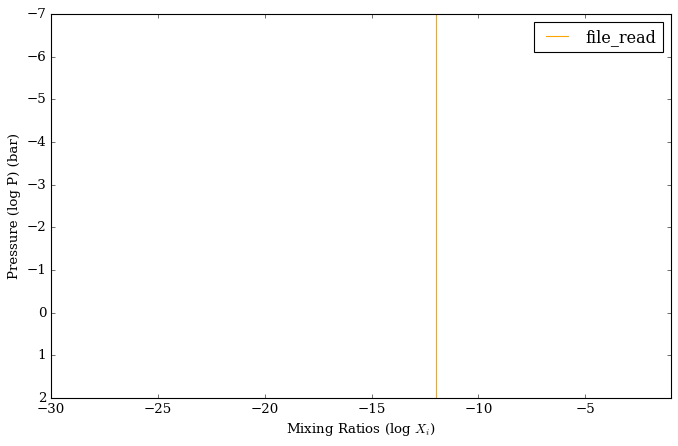

In [57]:
plot_clouds(planet,model_file_read,atmosphere_file_read)

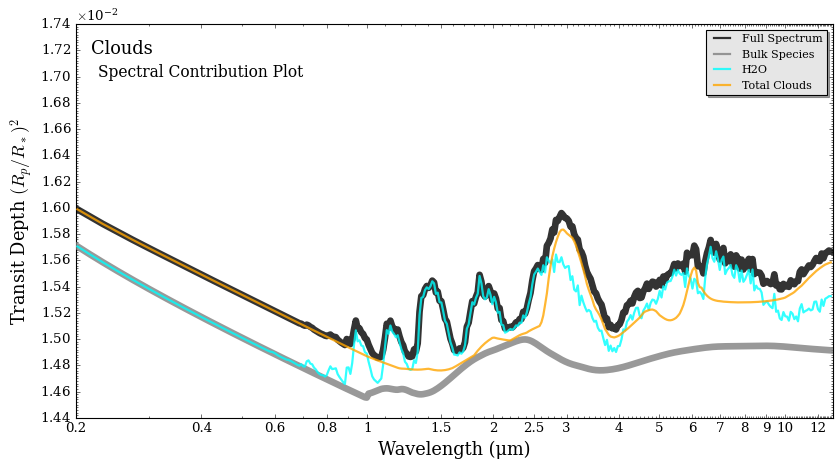

In [58]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_file_read,atmosphere_file_read, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

Now let's look at the constant refractive index with wavelength

In [59]:
# Constant refractive indices 
r_i_real, r_i_complex = 1, 1e-3 # <---- real refractive index, imaginary refractive index

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])

atmosphere_free = make_atmosphere(planet, model_free, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

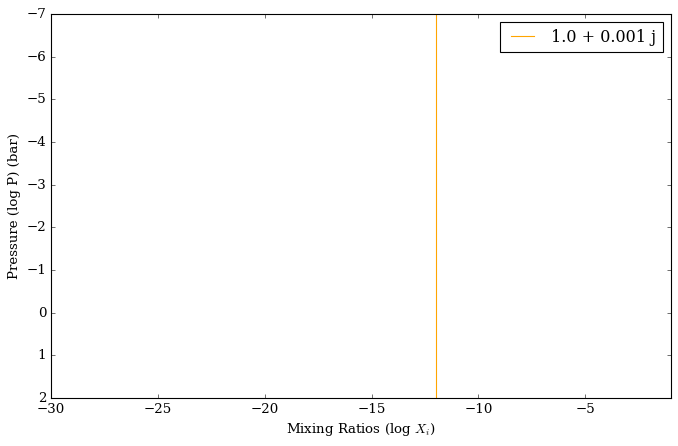

In [60]:
plot_clouds(planet,model_free,atmosphere_free)

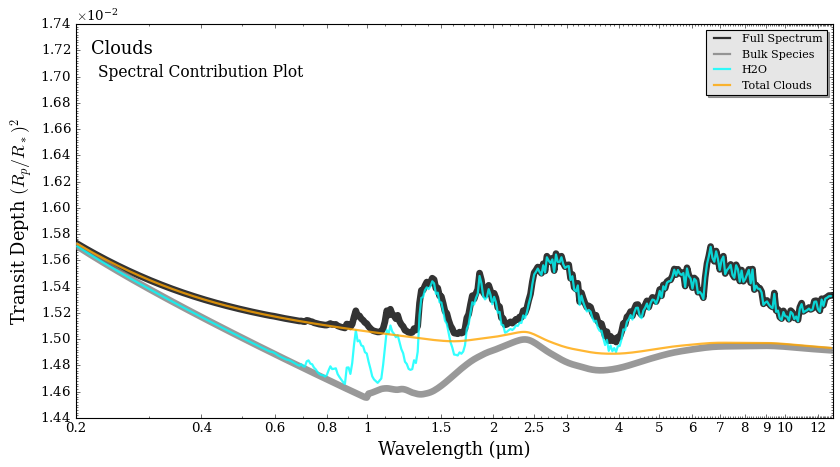

In [61]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_free,atmosphere_free, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

#### Cloud Dimension

Mie clouds also support a 1 + 1D prescription for patchy clouds. 

1 + 1D patchy clouds computes two spectra, one clear and one cloudy, and takes a weighted average of the two.

This prescription works with all the cloud models above, but for simplicity we will utilize Uniform X.

In [62]:
model_name = 'Uniform_X_patchy'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_uniform_x_patchy = define_model(model_name, bulk_species, param_species,
                        PT_profile = 'isotherm', X_profile = 'isochem',
                        cloud_model = 'Mie',cloud_type = 'uniform_X',
                        aerosol_species = aerosol_species,
                        cloud_dim = 2,   # <---- cloud_dim = 2 specifies you want 1 + 1D patchy clouds
                        ) 

print()
print("Cloud parameters (Uniform X Patchy) : " + str(model_uniform_x_patchy['cloud_param_names']))

Reading in database for aerosol cross sections...

Cloud parameters (Uniform X Patchy) : ['f_cloud' 'log_r_m_SiO2' 'log_X_SiO2']


The new parameter here is f_cloud, which describes the fractional coverage of aerosols on the terminator (or, more specifically, the weight used to weight the clear and cloudy spectra)

In [63]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

f_cloud             = 0.5  # <---- Fractional coverage is 50%
log_r_m_SiO2        = -2
log_X_SiO2          = -12

cloud_params = ([f_cloud, log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x_patchy = make_atmosphere(planet, model_uniform_x_patchy, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Reading in database for aerosol cross sections...


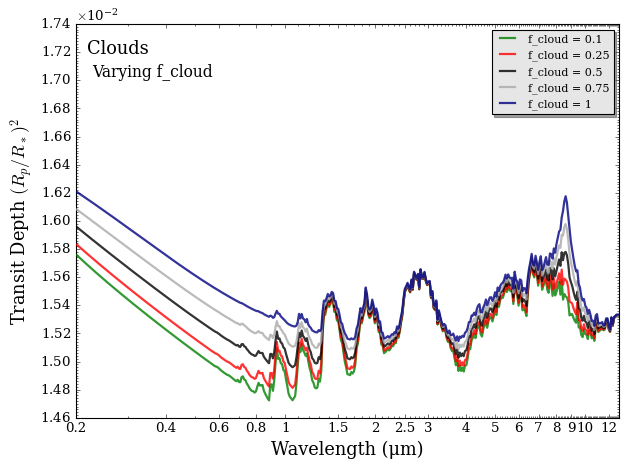

In [64]:
param_name = 'f_cloud'
vary_list = [0.1, 0.25, 0.5, 0.75, 1]

vary_one_parameter(model_uniform_x_patchy, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

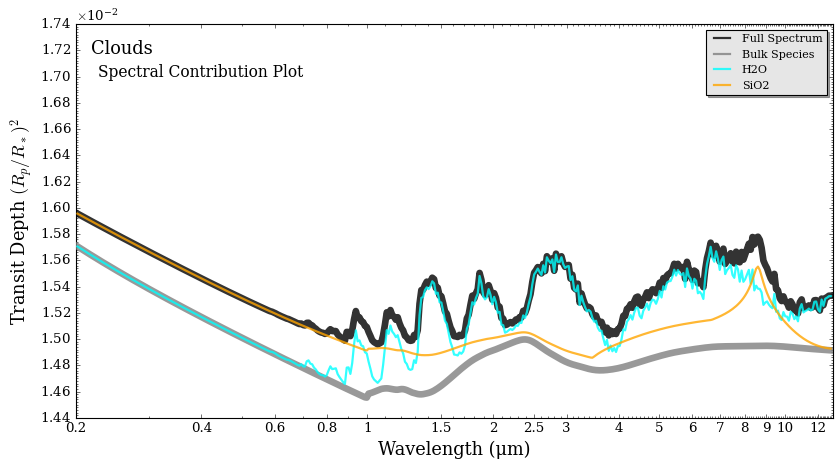

In [65]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x_patchy,atmosphere_uniform_x_patchy, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'],)

### Retrieval Considerations

All the above cloud models works with atmospheric retrievals. Please see the retrieval-focused tutorials (e.g. [\"Atmospheric Retrievals with POSEIDON\"](retrieval_basic.html)) to see how to set priors and run retrievals with POSEIDON. For Mie scattering retrieval prior recommendations, please refer to Mullens 2024. 